In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
# import torchvision.transforms as transforms
# from mpl_toolkits.axes_grid1 import ImageGrid
# from torchvision.utils import save_image, make_grid

In [2]:
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        self.features = self.data.iloc[:, :-1].values
        # self.labels = self.data.iloc[:, -1].values

        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # sample = {
        #     'features': torch.tensor(self.features[idx], dtype=torch.float32),
        #     'label': torch.tensor(self.labels[idx], dtype=torch.long)
        #     }
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        return sample
    
    # def get_label_encoder(self):
    #     return self.label_encoder

In [3]:
def createDataLoader(train_csv, test_csv, batch_size=32):
    scaler = StandardScaler()

    train_dataset = CSVDataset(train_csv, transform=scaler)
    test_dataset = CSVDataset(test_csv, transform=scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, test_dataset, train_loader, test_loader

In [4]:
train_csv = 'dataset/hars/train.csv'
test_csv = 'dataset/hars/test.csv'

train_dataset, test_dataset, train_loader, test_loader = createDataLoader(train_csv, test_csv)

In [5]:
print(len(train_dataset), len(train_loader), len(test_loader))

7352 230 93


In [6]:
for x in train_loader:
    print(x.shape) # (batch_size, seq_len, input_dim)
    break

torch.Size([32, 1, 562])


In [7]:
for batch_idx, batch in enumerate(train_loader):
    print(batch.shape)
    break

torch.Size([32, 1, 562])


In [8]:
# encoded_labels = [0, 1, 2, 3, 4, 5]  # Exemplo de labels codificados
# decoded_labels = train_dataset.get_label_encoder().inverse_transform(encoded_labels)
# print(decoded_labels)

In [9]:
# class VAE(nn.Module):
#     def __init__(self, input_dim, device, hidden_dim=400, latent_dim=20):
#         super(VAE, self).__init__()

#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, latent_dim * 2),
#             nn.ReLU()
#             )
        
#         # latente mean and variance
#         # self.mean_layer = nn.Linear(latent_dim, 2)
#         # self.logvar_layer = nn.Linear(latent_dim, 2)

#         # decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim),
#             # nn.Sigmoid()
#             nn.ReLU()
#         )
    
#     # def encode(self, x):
#     #     x = self.encoder(x)
#     #     return self.mean_layer(x), self.logvar_layer(x)
    
#     def reparameterization(self, mean, var):
#         std = torch.exp(0.5 * var)
#         eps = torch.randn_like(std)
#         return mean + eps * std
#         # epsilon = torch.randn_like(var).to(device)
#         # return mean + var * epsilon
    
#     # def decode(self, x):
#     #     return self.decoder(x)
    
#     def forward(self, x):
#         z_mean_logvar = self.encoder(x)
#         mean, logvar = torch.chunk(z_mean_logvar, 2, dim=-1)
#         z = self.reparameterization(mean, logvar)
#         x_hat = self.decoder(z)
#         return x_hat, mean, logvar

In [10]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False)
        self.output_layer = nn.Linear(input_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1, :, :]
        mean = self.hidden2mean(h_n)
        logvar = self.hidden2logvar(h_n)
        return mean, logvar
    
    def decode(self, z, seq_len):
        hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        output, _ = self.decoder_lstm(hidden)
        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len)
        return recon_x, mean, logvar

In [11]:
# Definir parâmetros do modelo
input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 1
learning_rate = 0.001
# batch_size = 32
epochs = 100

print(input_dim)

562


In [12]:
def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # mse
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
print(device)

# model = VAE(input_dim, device).to(device)
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

mps


In [14]:
print(model)

TemporalVAE(
  (encoder_lstm): LSTM(562, 128, batch_first=True, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 562, batch_first=True)
  (output_layer): Linear(in_features=562, out_features=562, bias=True)
)


In [15]:
def evaluate_metrics(x, recon_x):
    x = x.view(-1).detach().cpu().numpy()
    recon_x = recon_x.view(-1).detach().cpu().numpy()
    
    mse = mean_squared_error(x, recon_x)
    mae = mean_absolute_error(x, recon_x)
    rmse = mse ** 0.5
    r2 = r2_score(x, recon_x)
    
    return mse, mae, rmse, r2

def train_vae(model, train_loader, optimizer, device):
    model.train()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    for x in train_loader:
        data = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(data)
        loss = loss_function(data, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
        mse_total += mse
        mae_total += mae
        rmse_total += rmse
        r2_total += r2
    avg_train_loss = overall_loss / len(train_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_train_loss, avg_mse, avg_mae, avg_rmse, avg_r2

def val_vae(model, val_loader, device):
    model.eval()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    with torch.no_grad():
        for x in val_loader:
            data = x.to(device)
            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            overall_loss += loss.item()
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2
    avg_val_loss = overall_loss / len(val_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_val_loss, avg_mse, avg_mae, avg_rmse, avg_r2

In [16]:
def train(model, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    
    train_mse = []
    train_mae = []
    train_rmse = []
    train_r2 = []

    val_mse = []
    val_mae = []
    val_rmse = []
    val_r2 = []
    for epoch in range(epochs):
        train_loss, mse_train, mae_train, rmse_train, r2_train = train_vae(model=model, train_loader=train_loader, optimizer=optimizer, device=device)
        val_loss, mse_val, mae_val, rmse_val, r2_val = val_vae(model=model, val_loader=test_loader, device=device)
        train_losses.append(train_loss)
        train_mse.append(mse_train)
        train_mae.append(mae_train)
        train_rmse.append(rmse_train)
        train_r2.append(r2_train)

        val_losses.append(val_loss)
        val_mse.append(mse_val)
        val_mae.append(mae_val)
        val_rmse.append(rmse_val)
        val_r2.append(r2_val)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2

In [17]:
train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2 = train(model, optimizer, epochs, device)

Epoch [1/100], Train Loss: 299.6530, Val Loss: 271.9236
Epoch [2/100], Train Loss: 233.5263, Val Loss: 236.1705
Epoch [3/100], Train Loss: 212.9063, Val Loss: 227.8631
Epoch [4/100], Train Loss: 203.5320, Val Loss: 225.1679
Epoch [5/100], Train Loss: 193.7537, Val Loss: 217.2403
Epoch [6/100], Train Loss: 186.9817, Val Loss: 213.3884
Epoch [7/100], Train Loss: 180.8658, Val Loss: 209.8195
Epoch [8/100], Train Loss: 176.4439, Val Loss: 209.1658
Epoch [9/100], Train Loss: 172.5410, Val Loss: 210.1962
Epoch [10/100], Train Loss: 168.7333, Val Loss: 210.4983
Epoch [11/100], Train Loss: 164.5894, Val Loss: 205.2189
Epoch [12/100], Train Loss: 161.4990, Val Loss: 204.7922
Epoch [13/100], Train Loss: 158.1390, Val Loss: 208.0011
Epoch [14/100], Train Loss: 154.8165, Val Loss: 201.3236
Epoch [15/100], Train Loss: 152.7751, Val Loss: 201.1488
Epoch [16/100], Train Loss: 150.9918, Val Loss: 202.5549
Epoch [17/100], Train Loss: 149.3085, Val Loss: 204.7781
Epoch [18/100], Train Loss: 148.9928, Va

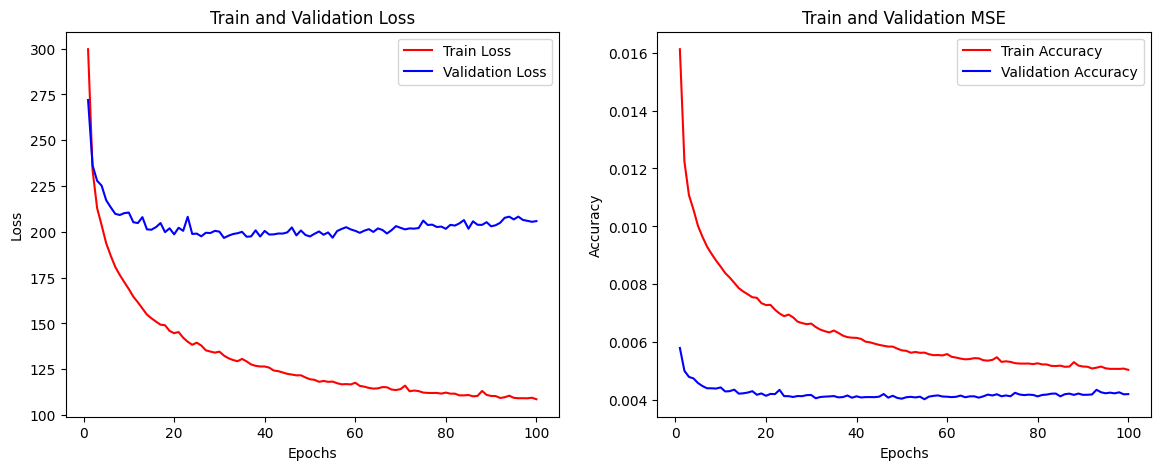

In [19]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 152 epocas porque com early stopping so rodou 152 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_mse, 'r', label='Train Accuracy')
plt.plot(epocas, val_mse, 'b', label='Validation Accuracy')
plt.title('Train and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Average MSE: 0.0105, Average MAE: 0.0108, Average RMSE: 0.0182, Average R²: 0.0209


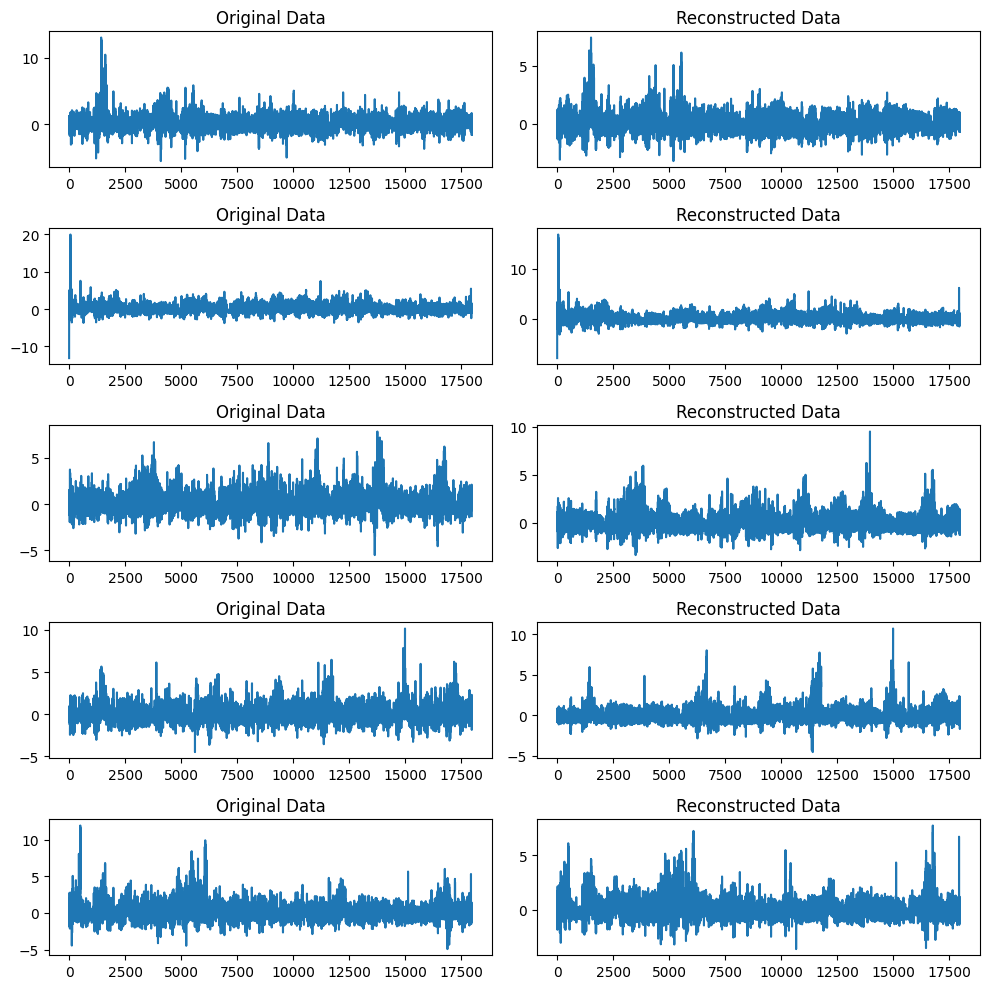

In [23]:
def evaluate_similarity(model, data_loader, device):
    model.eval()
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0

    with torch.no_grad():
        for x in data_loader:
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # Calcular métricas de similaridade
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2

    avg_mse = mse_total / len(data_loader.dataset)
    avg_mae = mae_total / len(data_loader.dataset)
    avg_rmse = rmse_total / len(data_loader.dataset)
    avg_r2 = r2_total / len(data_loader.dataset)

    return avg_mse, avg_mae, avg_rmse, avg_r2

def plot_reconstruction(data_loader, model, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            if i >= num_samples:
                break
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # original = data[0].cpu().numpy()
            # reconstructed = x_hat[0].cpu().numpy()
            original = data.view(-1).detach().cpu().numpy()
            reconstructed = x_hat.view(-1).detach().cpu().numpy()
            
            axs[i, 0].plot(original, label='Original')
            axs[i, 1].plot(reconstructed, label='Reconstructed')
            
            axs[i, 0].set_title('Original Data')
            axs[i, 1].set_title('Reconstructed Data')
    
    plt.tight_layout()
    plt.show()

avg_mse, avg_mae, avg_rmse, avg_r2 = evaluate_similarity(model, test_loader, device)
print(f'Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Average RMSE: {avg_rmse:.4f}, Average R²: {avg_r2:.4f}')

plot_reconstruction(test_loader, model, device)